# Goal:

- provide a plaintext interface to analyze step-by-step what is happening in the encrypted code

- Used as a Python sanity check because I'm not that familiar with R.

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import tqdm
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(42)

from numba import njit

In [2]:
@njit
def sigmoid(z):
    return 1/(1 + np.exp(-z))

@njit
def fwd(train_x, betas, dbg=False):
    preds = train_x @ betas
    return np.expand_dims(sigmoid(preds), -1)

@njit
def calculate_gradient(train_x, train_y, betas, fwd, dbg):
    preds = fwd(train_x, betas, dbg)
    gradient = -train_x.T @ (train_y - preds)  / len(train_y)
    return gradient

def cost(x, y, theta):
    m = x.shape[0]
    h = sigmoid(np.matmul(x, theta))
    
    t1 = np.matmul(-y.T, np.log(h))
    
    t2_a = (1 -y.T)
    t2_b = np.log(np.clip(1-h, 0.000000000000001, np.max(1-h)))  # Used to get numerical issues
    t2 = np.matmul(t2_a, t2_b)
    
    return ((t1 - t2) / m)[0]

def nesterov(train_x, train_y, betas, epochs, lr, mu, breakout=True):
    import copy

    phi = copy.deepcopy(betas)
    theta = copy.deepcopy(betas)
    
    #for i in tqdm.trange(epochs):
    nesterov_loss = [0 for _ in range(epochs)]
    prev_loss = None
    for i in range(epochs):
        gradient = calculate_gradient(train_x, train_y, theta, fwd, dbg=False)
        
        phi_prime = theta - lr * np.squeeze(gradient)

        if i == 0:
            theta = phi_prime
        else:
            theta = phi_prime + mu * (phi_prime - phi)

        phi = phi_prime
            
        loss = cost(train_x, train_y, theta)
        if not np.isfinite(loss):
            print("Hit a non-numerical loss. Breaking out of current config")
            break
        nesterov_loss[i] = loss
        
        if prev_loss and np.abs(loss - prev_loss) < 0.00005:
            break
        prev_loss = loss

        #print(f"New loss: {cost(train_x, train_y, v)[0]}")
    return nesterov_loss, loss, i, theta

# Load and Process the Data

In [4]:



def load_data(shuffle=True):
    X = pd.read_csv("../train_data/X_norm_37264.csv").to_numpy()    
    y = pd.read_csv("../train_data/y_37264.csv").to_numpy()
    idxs = np.random.permutation(len(X))
    
    if not shuffle:
        return X, y
    X = X[idxs]
    y = y[idxs]
    return X, y, len(X)

X, y, num_samples = load_data()


train_idx_end = round(0.85 * num_samples)
train_x, train_y = X[:train_idx_end], y[:train_idx_end]
test_x, test_y = X[train_idx_end:], y[train_idx_end:]

# Same shape as Marcelo's reference code
betas = np.zeros((10, ))

# Nesterov

In [5]:

lr = 0.1
mu = 0.1

r_script_nag_lr = 5.67349609
r_script_nag_mu = 0.8738939

ranges = [0.1, 0.2, 0.3]#, 0.4, 0.5, 0.75, r_script_nag_mu, 0.95, 1.2, 2.0, 3.0, r_script_nag_lr, 5.7]
lr_range = ranges
mu_range = ranges

lr_track = []
mu_track = []
loss_seq_tracker = [] 
final_loss_track = []
num_iters_track = []
weights_tracker = [] 
test_roc_auc_tracker = [] 
train_roc_auc_tracker = [] 
tracker = {}

for lr in tqdm.tqdm(lr_range):
    for mu in mu_range:        
        try:
            losses, final_loss, num_iters, weights =  nesterov(train_x, train_y, betas, 1_000, lr, mu)
            
            
            lr_track.append(lr)
            mu_track.append(mu)
            
            weights_tracker.append(weights)
            loss_seq_tracker.append(losses)
            if np.isfinite(final_loss):    
                num_iters_track.append(num_iters)
                train_predictions = np.squeeze(fwd(train_x, weights))
                train_roc_auc_tracker.append(roc_auc_score(np.squeeze(train_y), train_predictions))

                test_predictions = np.squeeze(fwd(test_x, weights))
                test_roc_auc_tracker.append(roc_auc_score(np.squeeze(test_y), test_predictions))
                final_loss_track.append(final_loss)
            else:
                num_iters_track.append(-1)
                train_roc_auc_tracker.append(0)
                test_roc_auc_tracker.append(0)
                final_loss_track.append(-1)
            ############################################################
            # Track the AUC/ROC
            ############################################################
                
        except Exception as e:
            print(e)
            print(f"Diverged on ({lr}, {mu})")    

100%|██████████| 3/3 [00:17<00:00,  5.72s/it]


In [6]:
idx_to_val = {}
val_to_idx = {}

for i, el in enumerate(lr_range):
    idx_to_val[i] = el
    val_to_idx[el] = i
    
    

x = [val_to_idx[v] for v in lr_track]
y = [val_to_idx[v] for v in mu_track]

[456.4 460.8 471.  489. ]


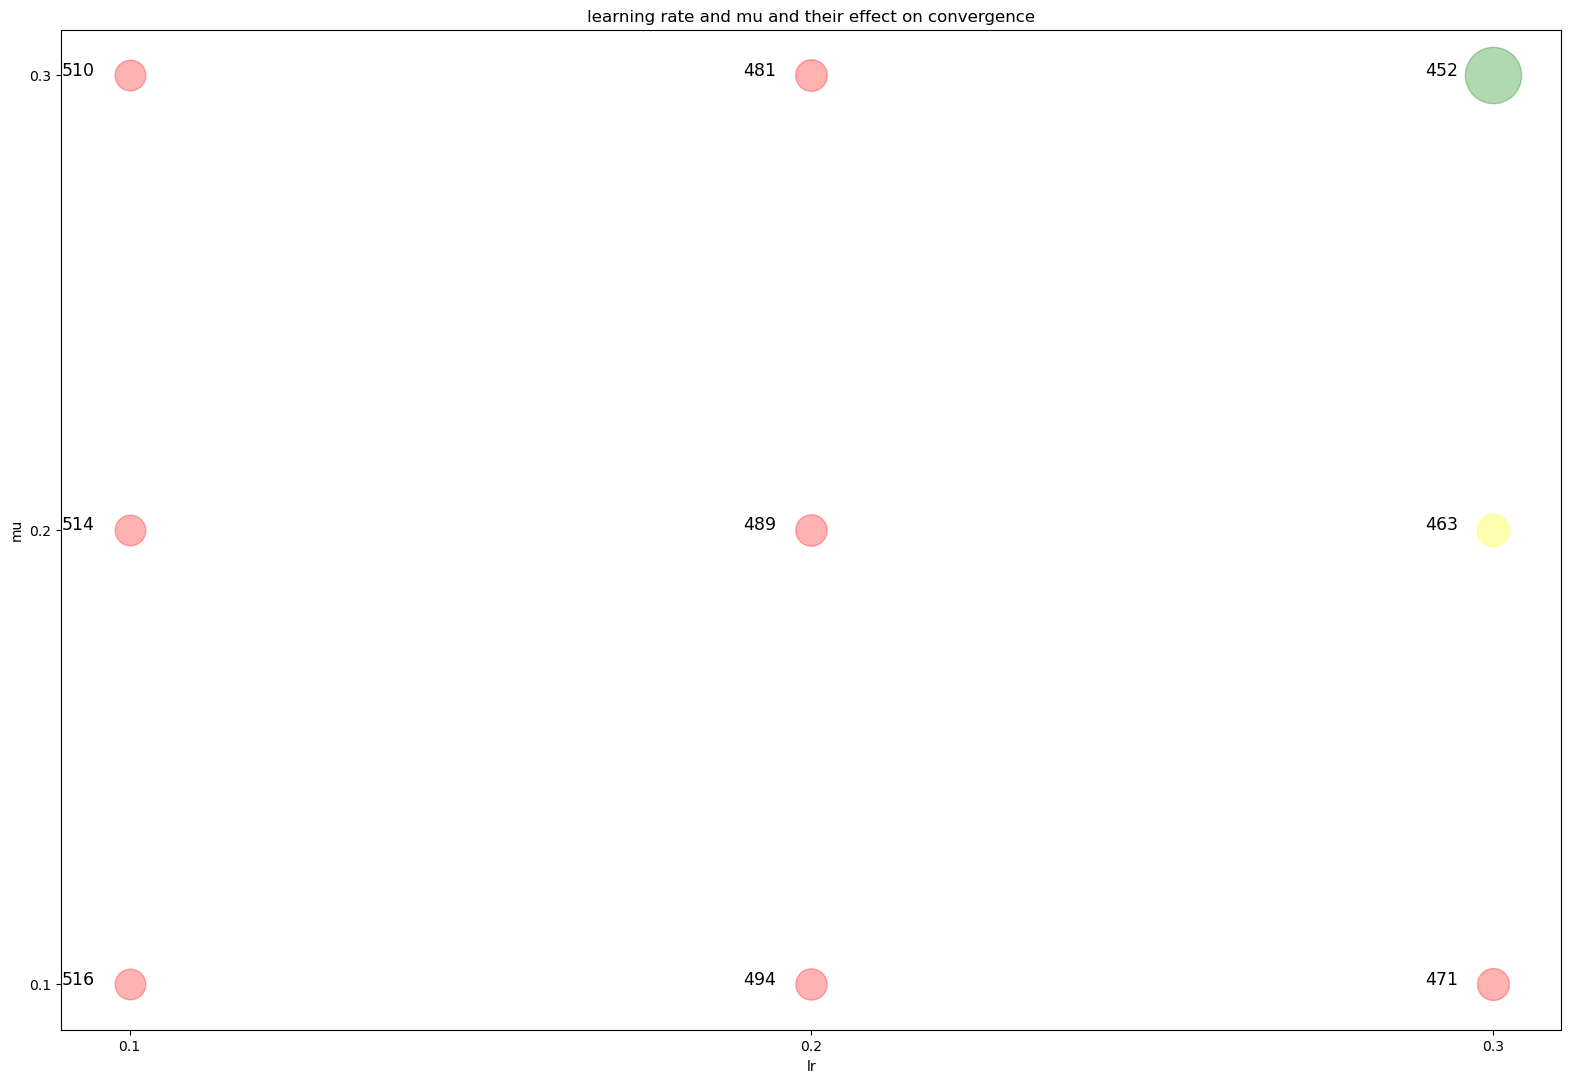

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,12)

def plot_convergence():
    # create data
    z = (1_000 - np.asarray(num_iters_track, dtype=np.float64))

    fig=plt.figure(figsize=(15,10))
    ax=fig.add_axes([0,0,1,1])


    #ax.scatter(x, y, s=z, cmap="Blues", alpha=0.25, edgecolors="grey", linewidth=2, )
    quantiles = np.quantile(
            np.asarray(num_iters_track)[np.asarray(num_iters_track) > 0],
            [0.05, 0.1, 0.25, 0.5]
        )

    print(quantiles)
    
    for (_lr, _mu, curr_iter, _z) in zip(x, y, num_iters_track, z):
        if curr_iter == -1:
            color = "black"
            _z = 0
        elif curr_iter < quantiles[0] and curr_iter != -1:
            color = "green"
            _z *= 3
        elif quantiles[0] < curr_iter < quantiles[1]:
            color = "blue"
            _z *= 2
        elif quantiles[1] < curr_iter < quantiles[2]:
            color = "yellow" 
            z *= 1
        else:
            color="red"
            
        ax.scatter(_lr, _mu, _z, c=color, alpha=0.3, )
        ax.annotate(curr_iter, (_lr-0.1, _mu), fontsize=12.5, )

    ax.set_xlabel("lr")
    ax.set_ylabel("mu")
    ax.set_title('learning rate and mu and their effect on convergence')

    plt.xticks(range(len(ranges)), ranges)
    plt.yticks(range(len(ranges)), ranges)

    # plt.savefig("plots/lr_mu_convergence.jpg", bbox_inches='tight', dpi=150)

    # Show the graph
    plt.show()
plot_convergence()

[0.27432595 0.27533108 0.27818834 0.2842177 ]


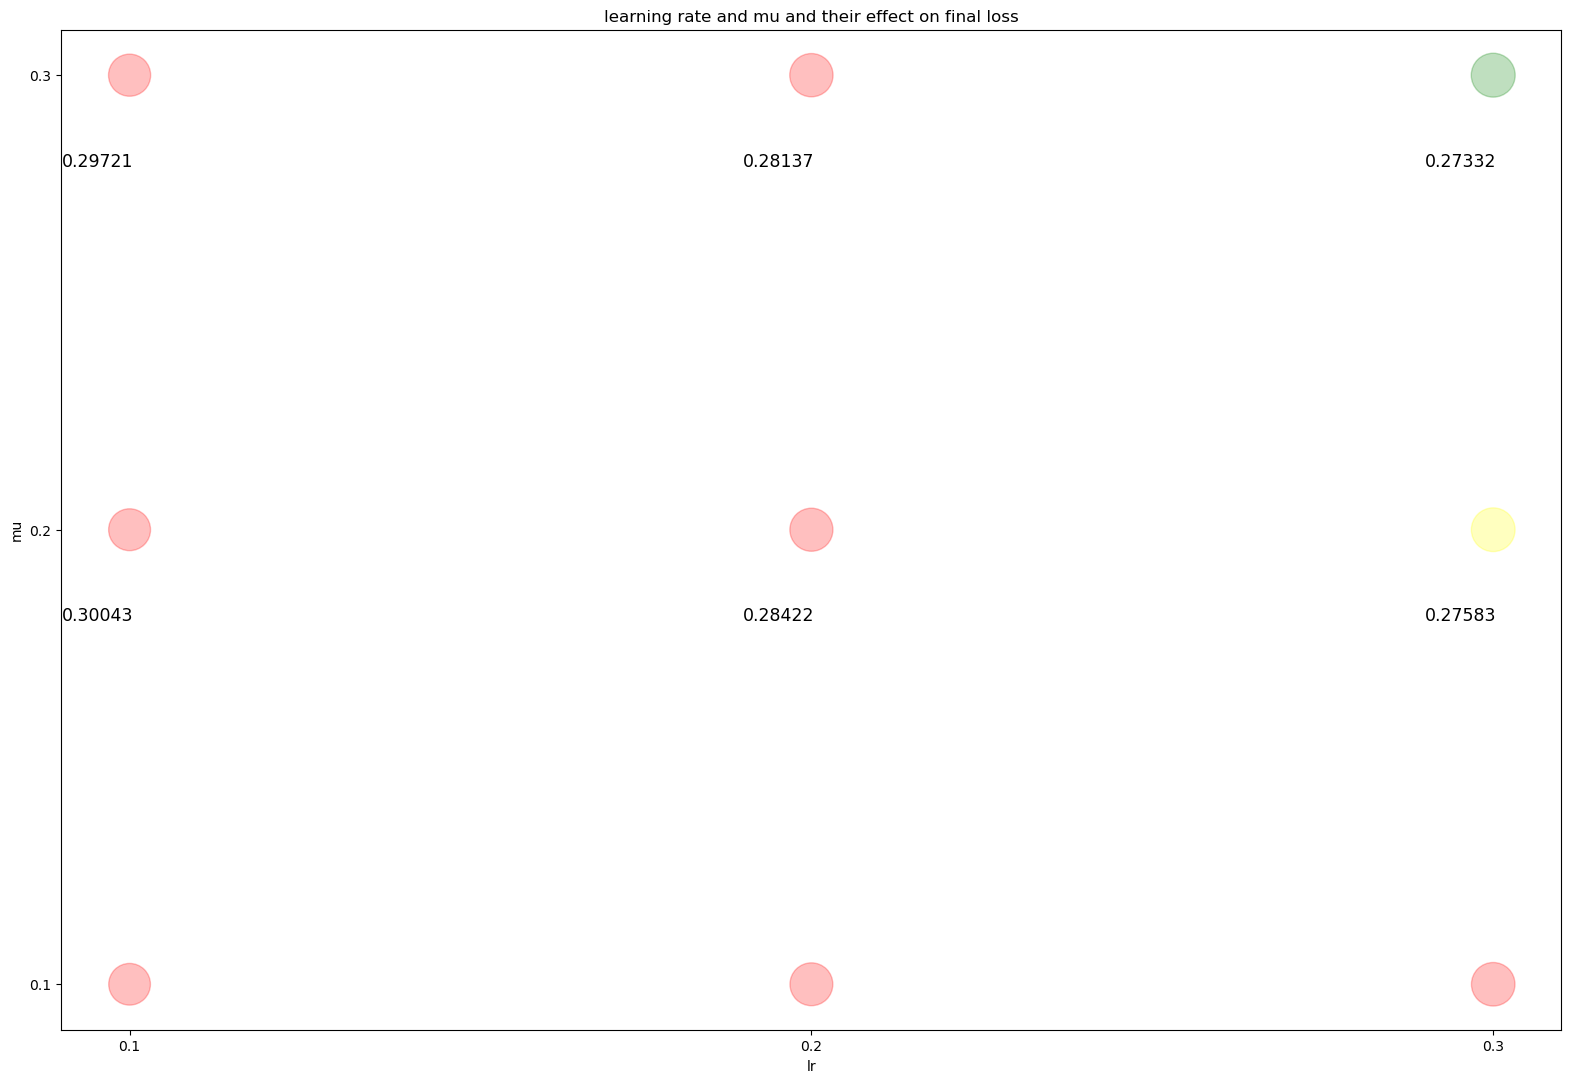

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,12)

def plot_loss():
    z = (np.asarray(final_loss_track, dtype=np.float64))
    masked_z = z[z >=0]
    z = (z / min(masked_z)) ** -1 * 1000

    fig=plt.figure(figsize=(15,10))
    ax=fig.add_axes([0,0,1,1])


    #ax.scatter(x, y, s=z, cmap="Blues", alpha=0.25, edgecolors="grey", linewidth=2, )
    quantiles = np.quantile(
            np.asarray(final_loss_track)[np.asarray(final_loss_track) > 0],
            [0.05, 0.1, 0.25, 0.5]
        )

    print(quantiles)
    colors= [] 
    
    for (_lr, _mu, curr_loss, _z) in zip(x, y, final_loss_track, z):
        if curr_loss == -1:
            color="black"
        if curr_loss < quantiles[0]:
            color = "green"
            _z += 500
        elif quantiles[0] < curr_loss < quantiles[1]:
            color = "blue"
            _z += 250
        elif quantiles[1] < curr_loss < quantiles[2]:
            color = "yellow"
            _z += 50
        else:
            color="r"
        colors.append(color)

        ax.annotate(f"{curr_loss:.5f}", (_lr-0.1, _mu-0.2), fontsize=12.5)
    ax.scatter(x, y, z, c=colors, alpha=0.25)
    # ax.scatter(x, y, s=z, cmap="Blues", alpha=0.25, edgecolors="grey", linewidth=2, )

    # for (_lr, _mu, curr_loss) in zip(x, y, final_loss_track):
    #     ax.annotate(f"{curr_loss:.5f}", (_lr-0.05, _mu-0.2), fontsize=12.5)


    ax.set_xlabel("lr")
    ax.set_ylabel("mu")
    ax.set_title('learning rate and mu and their effect on final loss')

    plt.xticks(range(len(ranges)), ranges)
    plt.yticks(range(len(ranges)), ranges)

    #plt.savefig("plots/final_loss.jpg", bbox_inches='tight', dpi=150)

    # Show the graph
    plt.show()
plot_loss()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,12)

def plot_aucroc(aucroc_scores, name):
    z = (np.asarray(aucroc_scores, dtype=np.float64)) * 1000

    fig=plt.figure(figsize=(15,10))
    ax=fig.add_axes([0,0,1,1])

    #ax.scatter(x, y, s=z, cmap="Blues", alpha=0.25, edgecolors="grey", linewidth=2, )
    quantiles = np.quantile(
            np.asarray(aucroc_scores)[np.asarray(aucroc_scores) > 0],
            [0.95, 0.9, 0.75, 0.5]
        )

    print(quantiles)
    
    colors = []
    for (_lr, _mu, aucroc, _z) in zip(x, y, aucroc_scores, z):
        if aucroc >= quantiles[0]:
            color = "green"
        elif quantiles[1] <= aucroc <quantiles[0] :
            color = "yellow"
        elif quantiles[2] < aucroc < quantiles[1]:
            color = "blue"
        else:
            color="red"
        colors.append(color)
        ax.annotate(f"{aucroc:.4f}", (_lr, _mu), fontsize=12.5, )
            
    ax.scatter(x, y, z, c=colors, alpha=0.5)
        


    ax.set_xlabel("lr")
    ax.set_ylabel("mu")
    ax.set_title(f'learning rate and mu and their effect on {name} AUC-ROC')

    plt.xticks(range(len(ranges)), ranges)
    plt.yticks(range(len(ranges)), ranges)

    #plt.savefig(f"plots/{name}_aucroc.jpg", bbox_inches='tight', dpi=150)

    # Show the graph
    plt.show()
    


[0.94919457 0.94886778 0.94797868 0.94660092]


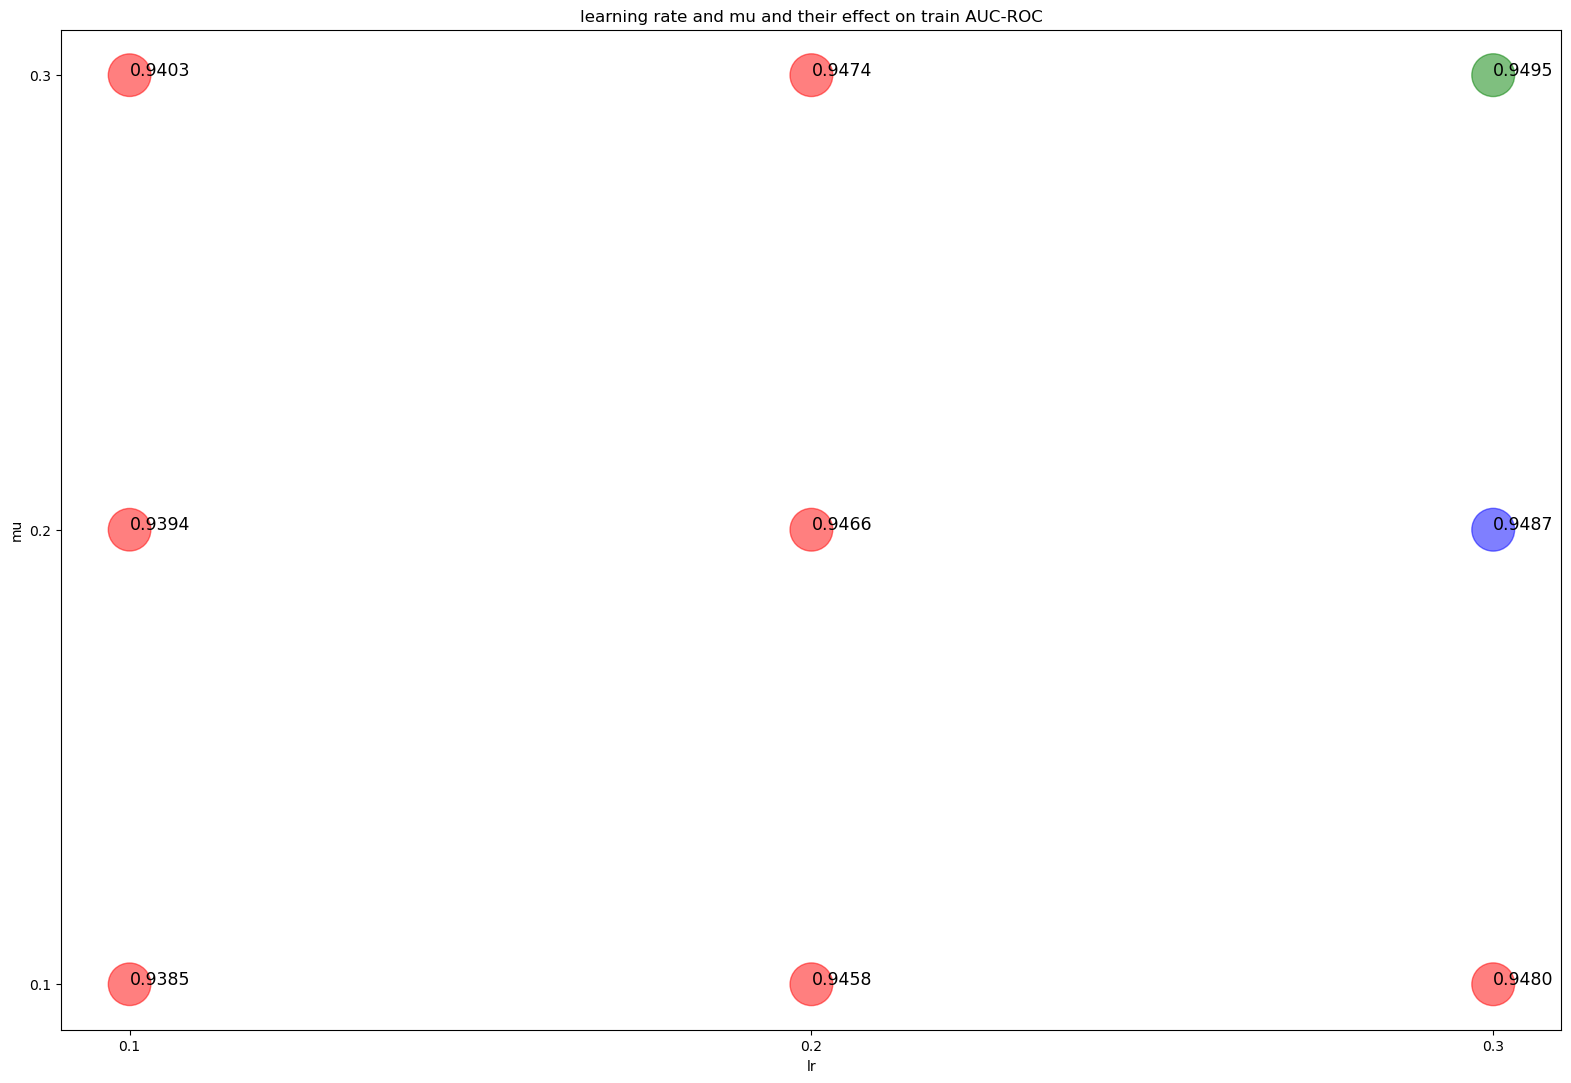

In [12]:
plot_aucroc(train_roc_auc_tracker, "train")

[0.95016193 0.94983259 0.94895965 0.9478319 ]


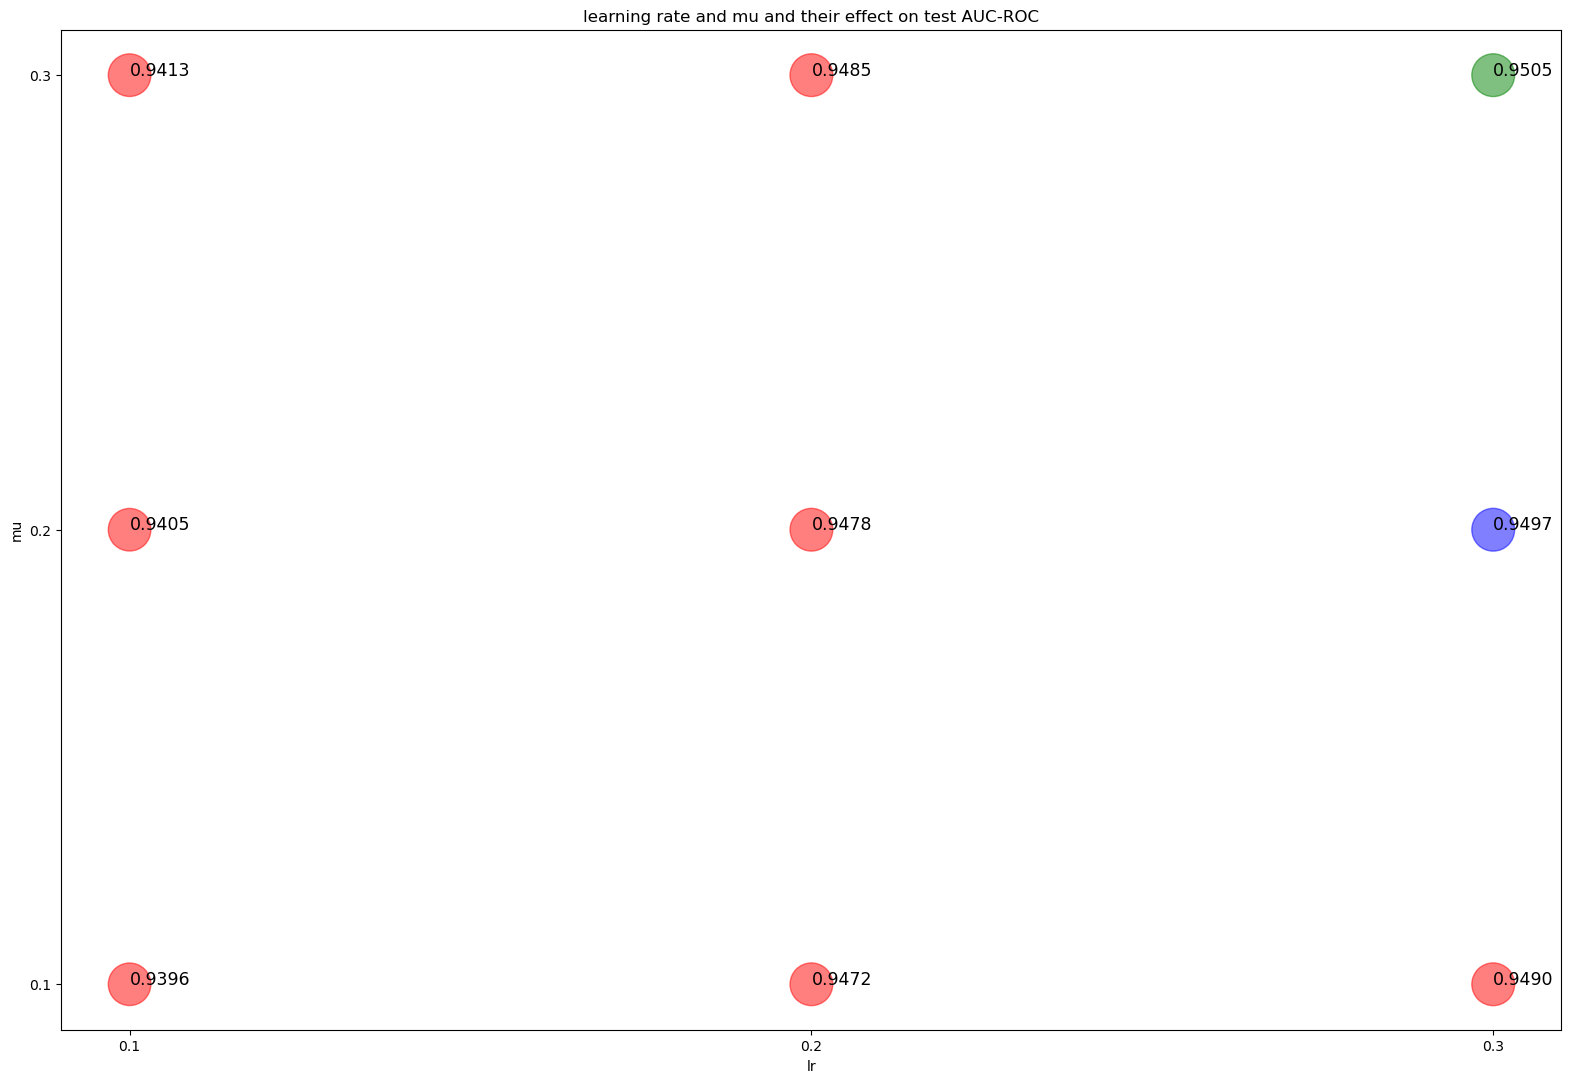

In [13]:
plot_aucroc(test_roc_auc_tracker, "test")